<a href="https://colab.research.google.com/github/jeffbgreene/geology-558/blob/main/Supervised_Regression_Final_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align:center;"><b> Supervised Regression - Meteorological
data from the Hawaii HI-SEAS weather station </b></h1>

#### Author: Jeff Greene
#### Date : 1/26/2025


The data set I am using for this module consists of meteorological data from the Hawaii HI-SEAS weather station for four months (September through December 2016) between Mission IV and Mission V that I found on Kaggle. According to their website:


> The Hawai‘i Space Exploration Analog and Simulation (HI-SEAS) is a Mars and Moon exploration analog research station, currently operated by the International MoonBase Alliance.
Located approximately 8,200 feet above sea level, the HI-SEAS habitat is a 1,200 square foot dome located on a Mars-like site on the Mauna Loa volcano on Hawai‘i Island. HI-SEAS has been the home to five successful long-duration (4 to 12 month) NASA Mars simulation missions and tens of other analog space missions in collaboration with multiple space agencies, companies, and organizations worldwide.




In [90]:
import os
import requests
from io import StringIO

# For preprocessing labels and splitting the data
# XGBoost and SciKit learn had a strange interaction, so I needed to add this code. This is described on
# Stack Overflow "Scikit-learn version 1.6 modified the API around its "tags", and that's the cause of this error.""
# https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

from sklearn import preprocessing
# To split the data, hyperparameter search and cross validation
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
import scipy.stats as stats
from scipy.stats import pearsonr

# Scoring metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

# Fro feature scoring, selection and as a testing model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#Support Vector Regressor
from sklearn.svm import SVR
# Linear Regression and other regression libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
# XGBoost
from xgboost import XGBRegressor

import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
!pip install plotly
import plotly.graph_objects as go # Import the plotly.graph_objects module

# Set the figure size
plt.rcParams["figure.figsize"] = (12,12)
# Set the default font size
plt.rcParams.update({'font.size': 12})

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


## **Load the data**

---


This step includes loading the data from the CSV. I have added included steps to validate the GitHub URL and data integrity, which I applied in a previous notebook to ensure my data is pulled in correctly.

In [2]:
def validate_file_path_github(file_url):
    """
    Validates if a file path from GitHub URL exists.
    """
    try:
        response = requests.head(file_url)
        if response.status_code == 200:
            print(f"File path '{file_url}' exists.")
            return True
        else:
             print(f"File path '{file_url}' does not exist. Status code: {response.status_code}")
             return False
    except requests.ConnectionError as e:
        print(f"Error connecting to {file_url}: {e}")
        return False
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return False

def validate_data_integrity_github(file_url, expected_columns, expected_data_types={}):
    """
    Validates data integrity after loading from a GitHub URL.
    """
    try:
        response = requests.get(file_url)
        response.raise_for_status()
        csv_content = StringIO(response.text)
        df = pd.read_csv(csv_content)
    except requests.exceptions.RequestException as e:
         print(f"Failed to fetch data from {file_url}: {e}")
         return False
    except pd.errors.ParserError as e:
        print(f"Failed to parse CSV content: {e}")
        return False

    # Check for expected columns
    if not all(col in df.columns for col in expected_columns):
        print(f"Data does not contain all expected columns. Expected: {expected_columns}, Found: {list(df.columns)}")
        return False

     # Check for data types
    for column, expected_type in expected_data_types.items():
        if column in df.columns:
            if df[column].dtype != expected_type:
                 print(f"Column '{column}' has type {df[column].dtype}, but expected {expected_type}")
                 return False

    print("Data integrity check passed.")
    return True

In [3]:
file_url = 'https://raw.githubusercontent.com/jeffbgreene/geology-558/main/SolarPrediction.csv'
expected_columns = ['UNIXTime', 'Data', 'Time', 'Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise', 'TimeSunSet']
expected_data_types = {'UNIXTime':'int64', 'Data':'object', 'Time':'object', 'Radiation':'float64', 'Temperature':'int64', 'Pressure':'float64', 'Humidity':'int64', 'WindDirection(Degrees)':'float64', 'Speed':'float64', 'TimeSunRise':'object', 'TimeSunSet':'object'}
if validate_file_path_github(file_url):
    if validate_data_integrity_github(file_url, expected_columns, expected_data_types):
      # Proceed with loading data
      df = pd.read_csv(file_url, index_col=None, header=0)
      print("Data has been validated and loaded.")
      df = df.sort_values(['UNIXTime'], ascending = [True])
      print("Data has been sorted by UNIXTime")
    else:
      print("Data integrity check failed.")
else:
    # Handle file not found error
    print(f"GitHub file: {file_url} does not exist")

File path 'https://raw.githubusercontent.com/jeffbgreene/geology-558/main/SolarPrediction.csv' exists.
Data integrity check passed.
Data has been validated and loaded.
Data has been sorted by UNIXTime


In a previous notebook it was suggested that the URL and data should be validated to ensure that it is read in correctly. I have taken the same approach here. I also sorted the data by the UNIX Time stamp (seconds elapsed since January 1st 1970).

## **Exploratory Data Analysis**


---
The original data consists of assorted time and numerical features. Numeric values represent various meteorological attributes. I included the complete EDA done in the previous notebook for refernce, which included engineering a feature for EDA related to the UNIX time as a time stamp. I will not use this feature for training however

The goal of this notebook is to use the eather elements as inputs to build models that can accurately predict the radiation as a numeric value. I had good results with XGBoost for the previous assignment, so I planned on using it again for this assignment.

**The features utilized for training are: Temperature, Pressure, Humidity, WindDirection, and speed.**

**My target variable for this assignment is Radiation**


In [4]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
7416,1472724008,9/1/2016 12:00:00 AM,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00
7415,1472724310,9/1/2016 12:00:00 AM,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00
7414,1472725206,9/1/2016 12:00:00 AM,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00
7413,1472725505,9/1/2016 12:00:00 AM,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00
7412,1472725809,9/1/2016 12:00:00 AM,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00


In [5]:
# Derive a new column called datetime for visualization use
df['UNIXDateTime'] = pd.to_datetime(df['UNIXTime'], unit='s')

In [6]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,UNIXDateTime
7416,1472724008,9/1/2016 12:00:00 AM,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00,2016-09-01 10:00:08
7415,1472724310,9/1/2016 12:00:00 AM,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00,2016-09-01 10:05:10
7414,1472725206,9/1/2016 12:00:00 AM,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00,2016-09-01 10:20:06
7413,1472725505,9/1/2016 12:00:00 AM,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00,2016-09-01 10:25:05
7412,1472725809,9/1/2016 12:00:00 AM,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00,2016-09-01 10:30:09


In [7]:
print(f"The length of the data set is {len(df)} rows")

The length of the data set is 32686 rows


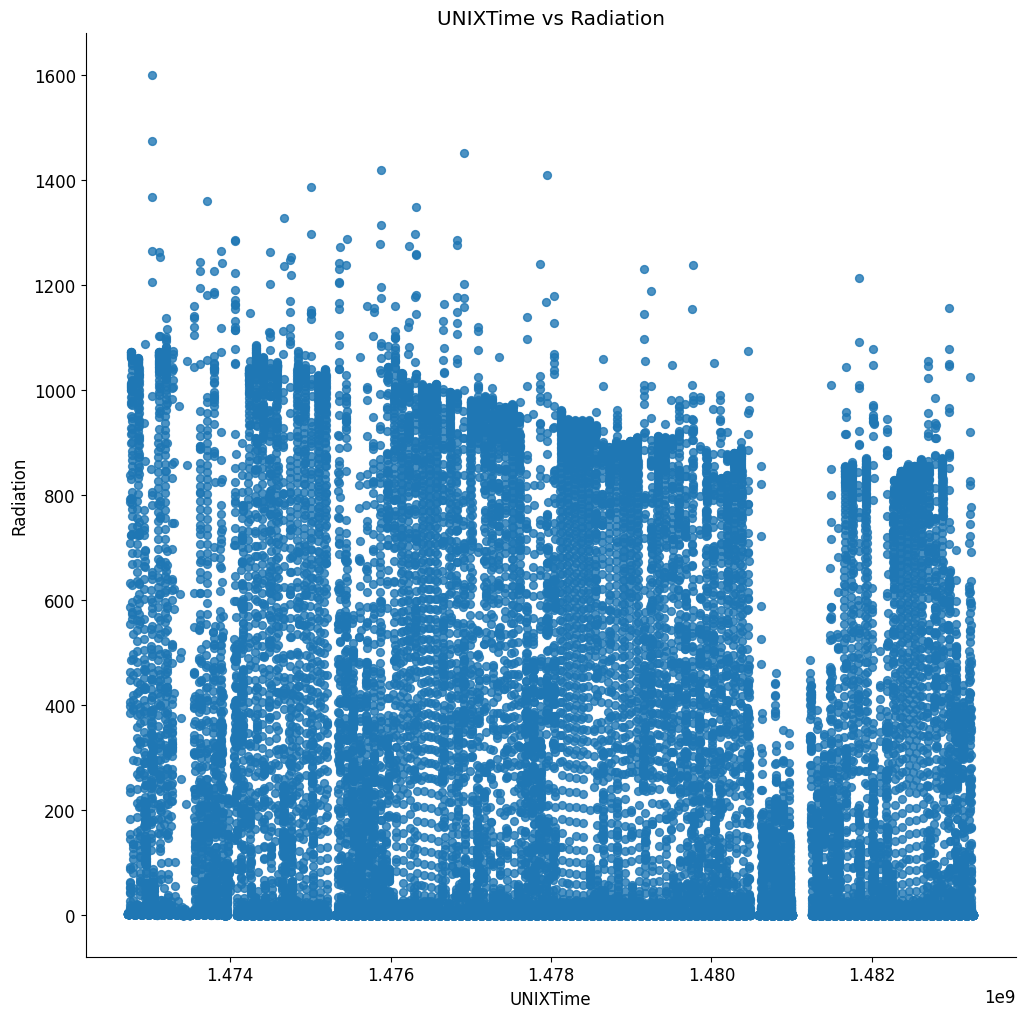

In [8]:
df.plot(kind='scatter', x='UNIXTime', y='Radiation', s=32, alpha=.8)
plt.title('UNIXTime vs Radiation')
plt.gca().spines[['top', 'right',]].set_visible(False)

### <p style="text-align:center;"><i>Figure 1: The time as a UNIX timestamp (number of seconds since January 1, 1970) vs radiation.</i></p>

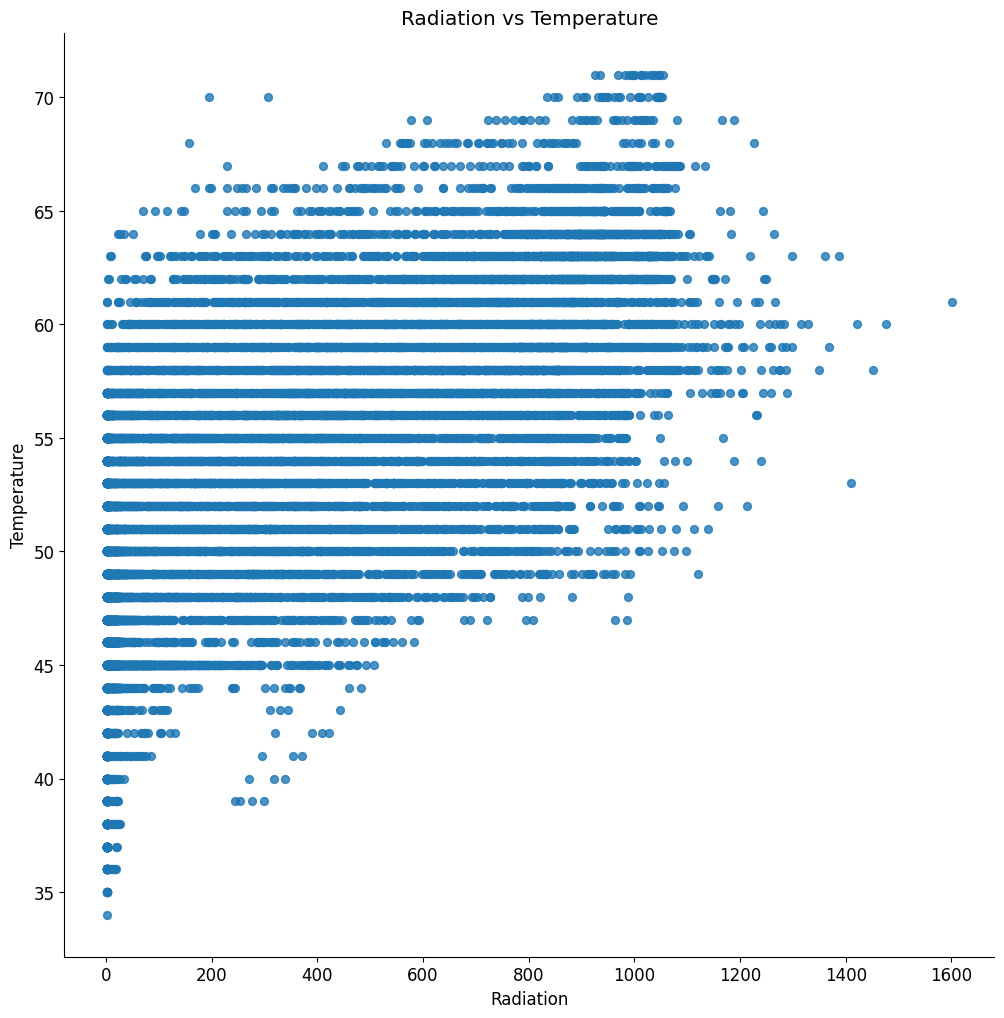

In [9]:
df.plot(kind='scatter', x='Radiation', y='Temperature', s=32, alpha=.8)
plt.title('Radiation vs Temperature')
plt.gca().spines[['top', 'right',]].set_visible(False)

### <p style="text-align:center;"><i>Figure 2: Radiation vs temperature .</i></p>

In [10]:
df.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,UNIXDateTime
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,2016-11-02 00:41:04.944808192
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,2016-09-01 10:00:08
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,2016-10-04 02:01:37.500000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,2016-11-01 18:47:49.500000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,2016-11-30 04:28:48
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,2017-01-01 09:55:01
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32686 entries, 7416 to 24522
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   UNIXTime                32686 non-null  int64         
 1   Data                    32686 non-null  object        
 2   Time                    32686 non-null  object        
 3   Radiation               32686 non-null  float64       
 4   Temperature             32686 non-null  int64         
 5   Pressure                32686 non-null  float64       
 6   Humidity                32686 non-null  int64         
 7   WindDirection(Degrees)  32686 non-null  float64       
 8   Speed                   32686 non-null  float64       
 9   TimeSunRise             32686 non-null  object        
 10  TimeSunSet              32686 non-null  object        
 11  UNIXDateTime            32686 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3), obje

I wanted to sort the data by the UNIX Timestamp to get a clear plot of any trends in radiation over the course of six months

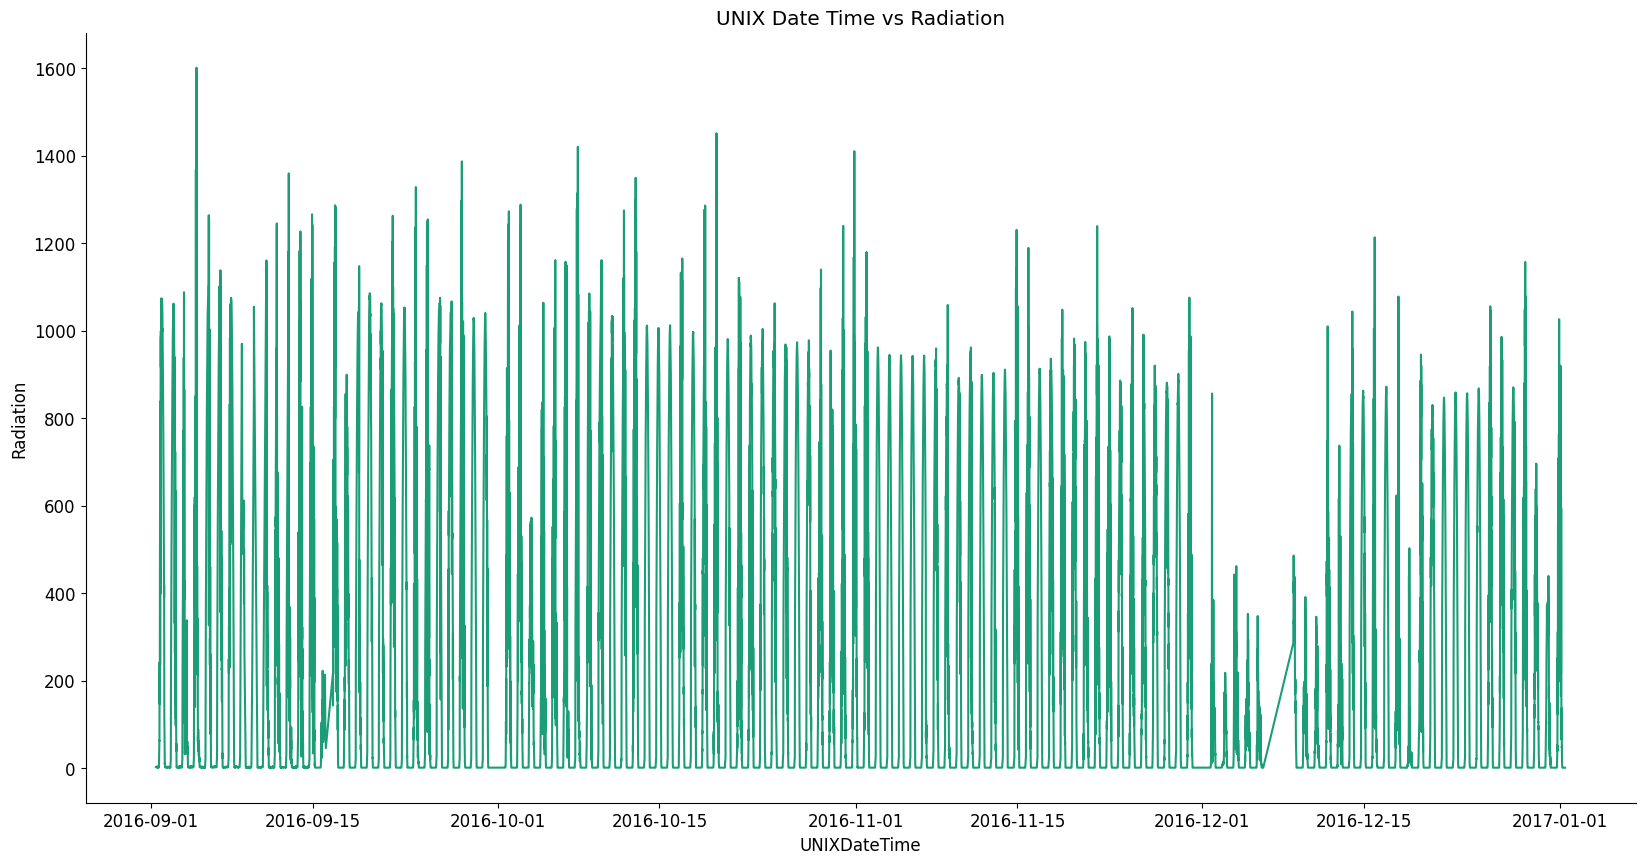

In [12]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['UNIXDateTime']
  ys = series['Radiation']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(20,10))

plt.title('UNIX Date Time vs Radiation')
_plot_series(df, '')

sns.despine(fig=fig, ax=ax)
plt.xlabel('UNIXDateTime')
_ = plt.ylabel('Radiation')

### <p style="text-align:center;"><i>Figure 3: I converted the timestamps to dates to visualize time vs radiation. The spikes seem to diminish as the end of summer changes to fall and then winter. I may need to account for this when splitting my data.</i></p>

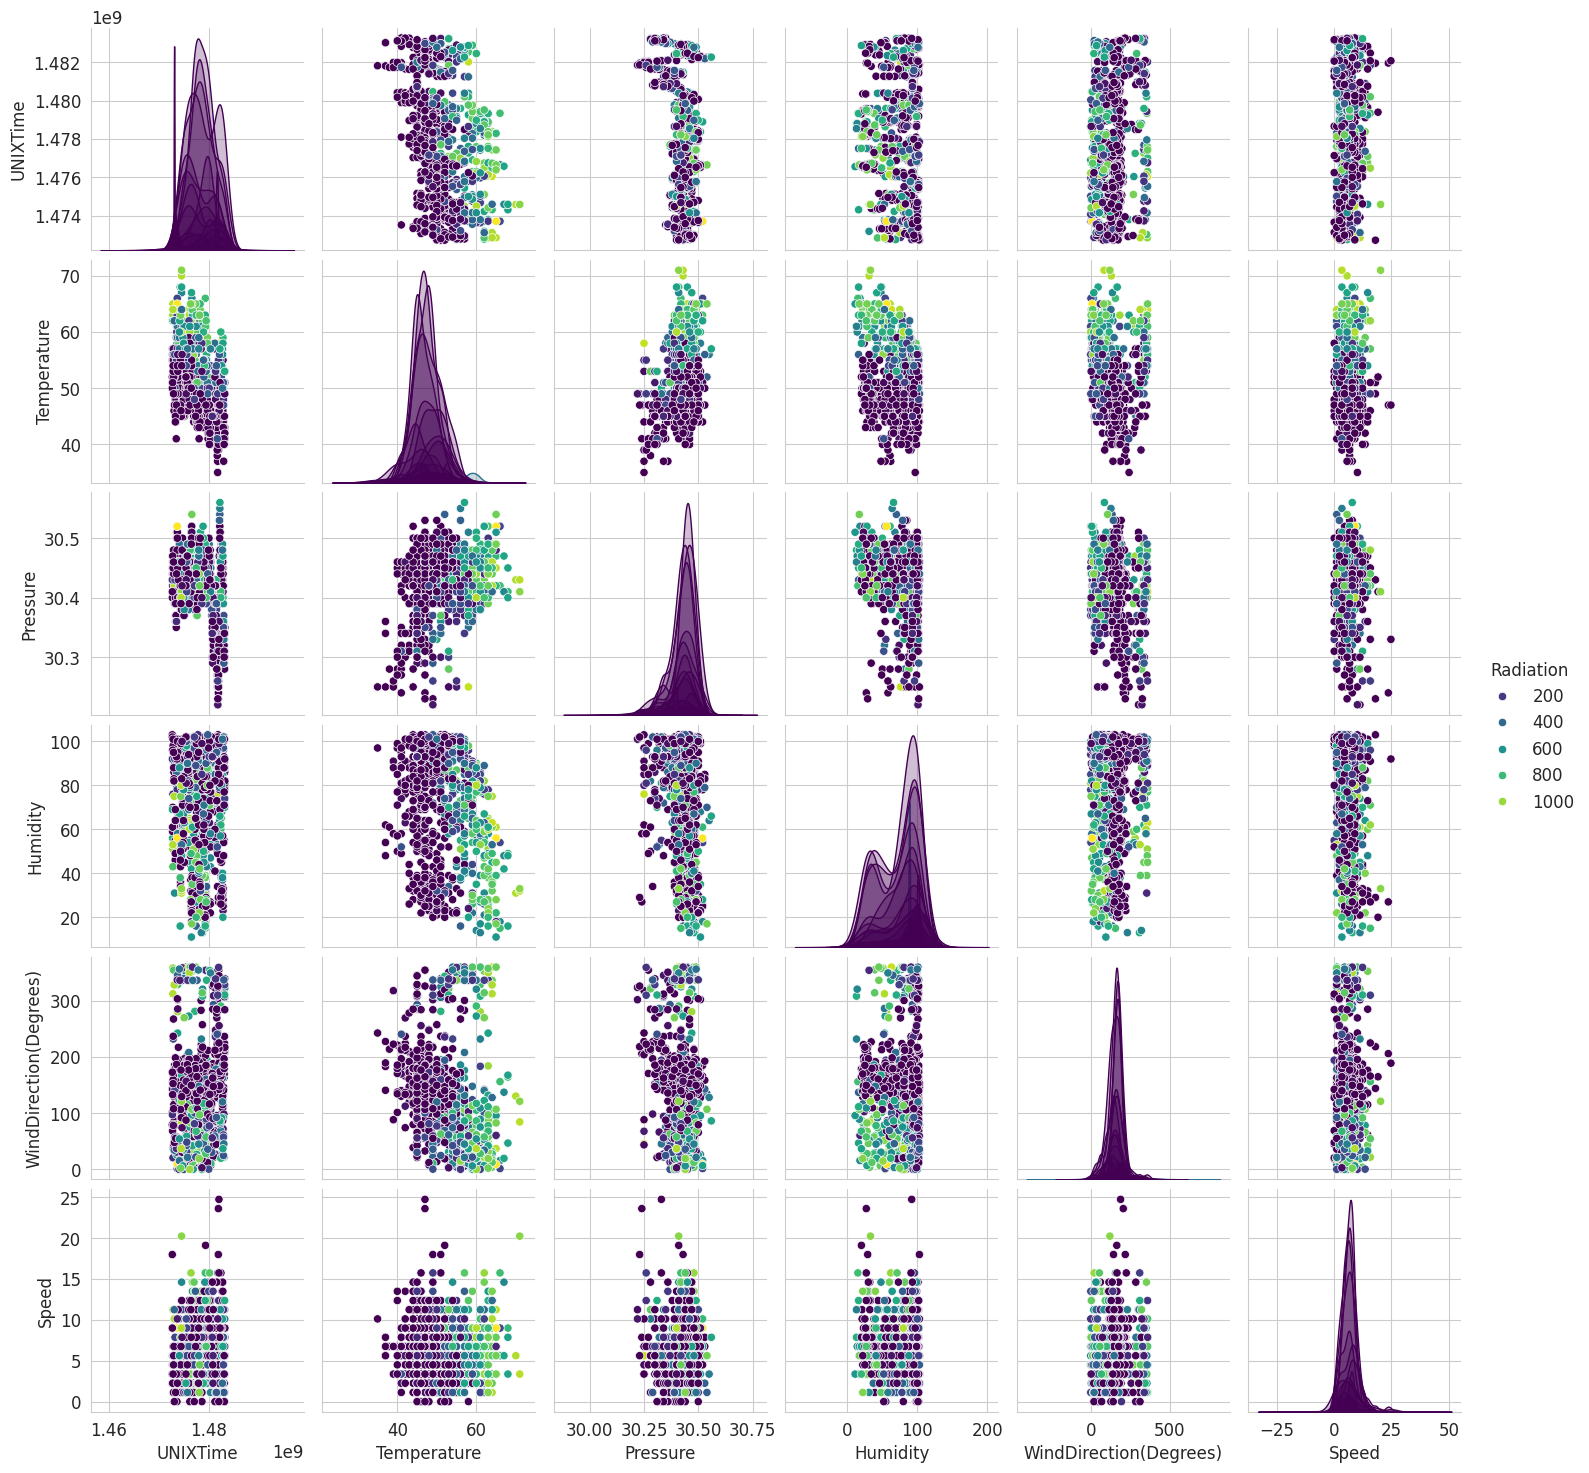

In [13]:
# Pairplots for the different features with Radiation as the hue
sns.set_style("whitegrid")
g = sns.pairplot(df.sample(n=1000), hue='Radiation', palette='viridis', diag_kind="kde", dropna=True)
plt.show()

### <p style="text-align:center;"><i>Figure 4: Pairplots for the various features with radiation as the hue</i></p>

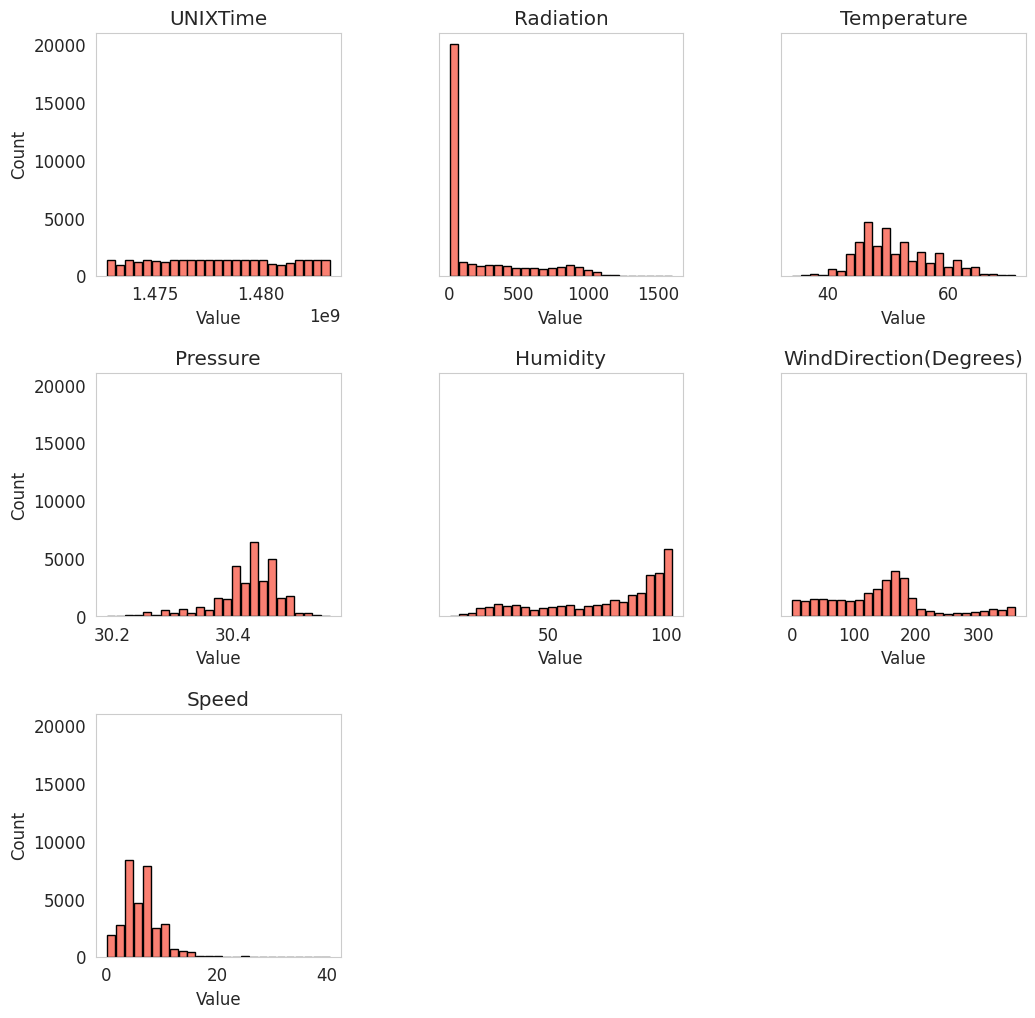

In [14]:
# Create a histogram of weight distribution counts for all samples
df_no_dates = df.drop(columns=['UNIXDateTime'])
ax = df_no_dates.hist(bins=25, grid=False, color='salmon', edgecolor='black', sharey=True, zorder=2, rwidth=0.9)
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust values as needed
# Loop through the plots and add labels to x and y axes
for chart in ax.flatten():
    chart.set_xlabel("Value")
    chart.set_ylabel("Count")


### <p style="text-align:center;"><i>Figure 5: Looking at the histograms, there is a slight left skew for humidity, possibly due to the changing seasons. There is also an extreme right skew for the radiation data. I will have to deal with this as radiation is the target variable.</i></p>

The radiation values are extremely right skewed, as discussed previously. Reagrdless, I have determined that the features are more important for proper regression, so I will consider feature engineering in hopes to improve performance.

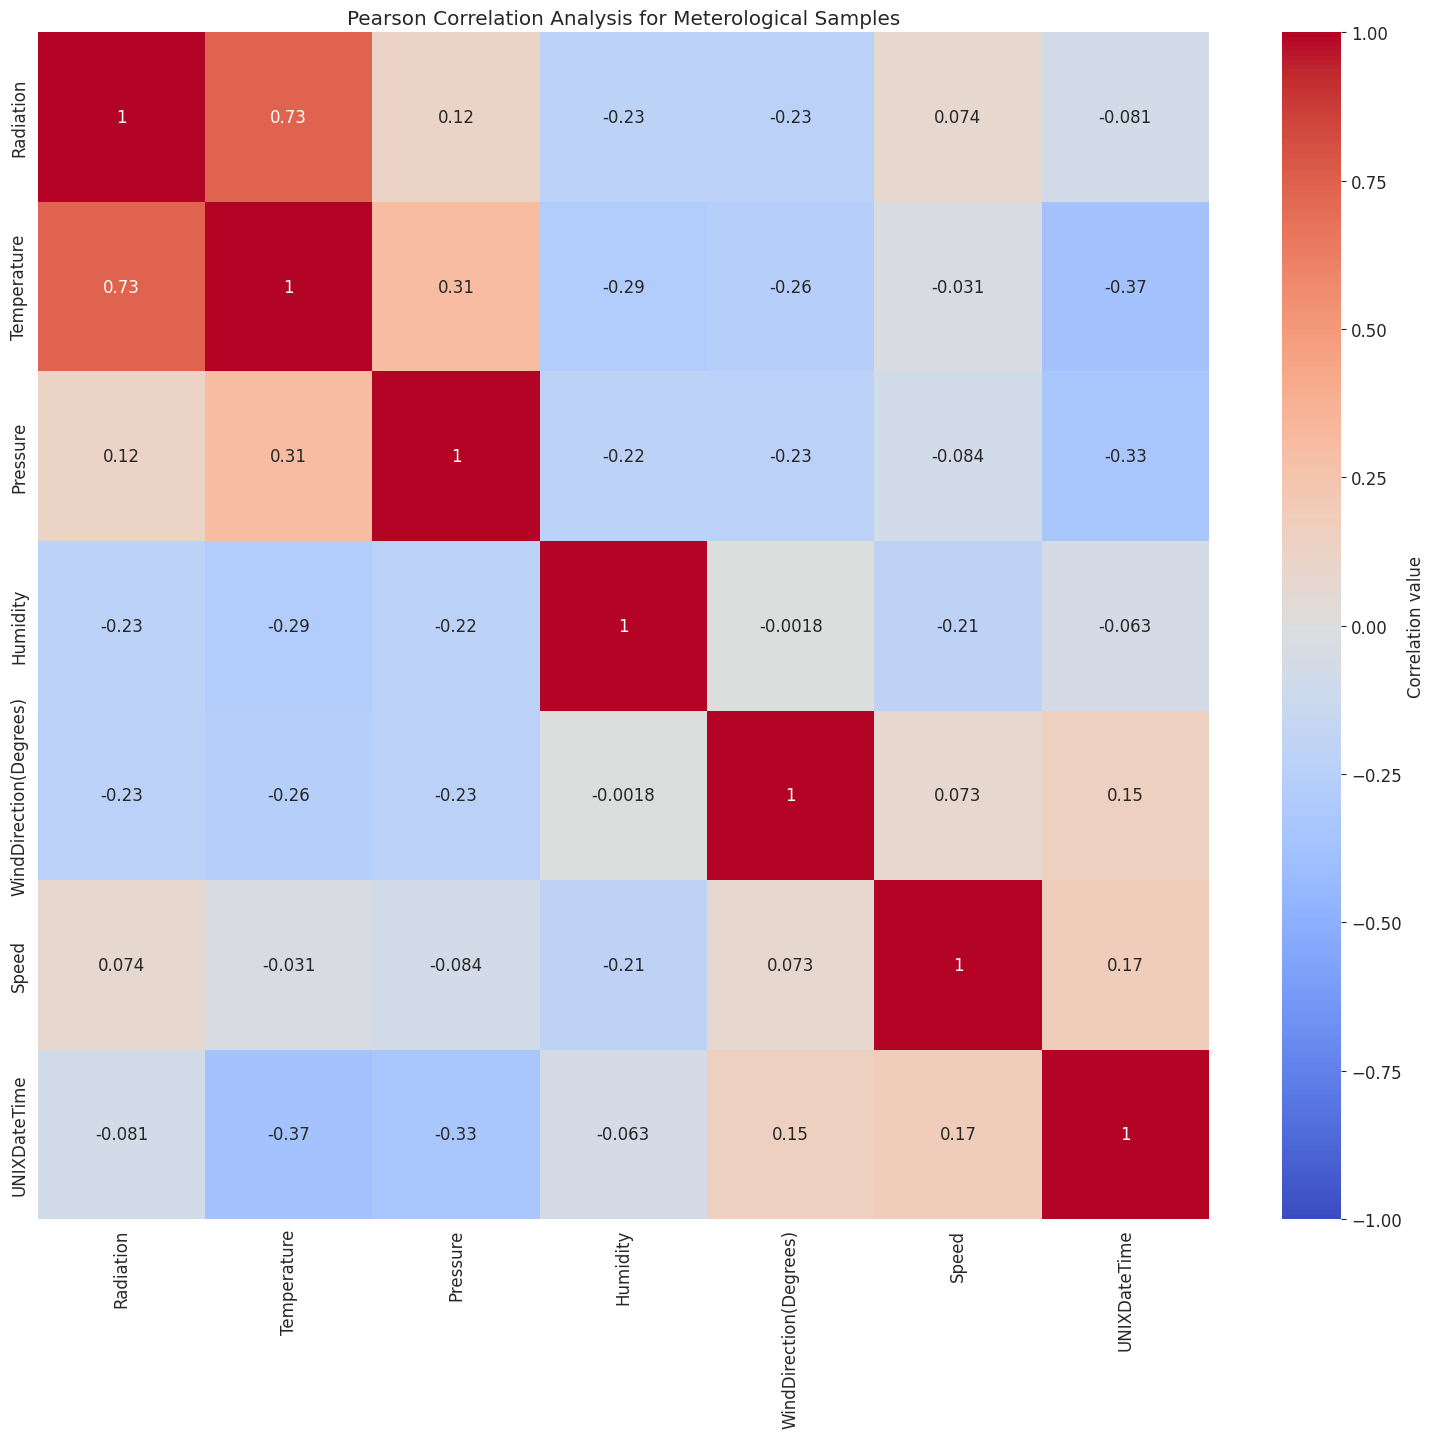

In [15]:
# Drop the Object columns
df_filtered = df.drop(columns=['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'])

fig, ax = plt.subplots(figsize=[15, 15], sharex=True)

# Calculate the correlation matrix, dropping all NaN rows and columns
correlation_matrix = df_filtered.corr(method='pearson').dropna(axis=0, how='all').dropna(axis=1, how='all')

# Plot the results of the correlation as a heatmap
sns.heatmap(correlation_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm', cbar_kws={'label': 'Correlation value'})
plt.title("Pearson Correlation Analysis for Meterological Samples")
ax.set_position([0.55, 0.1, 0.35, 0.8])  # Adjust position manually

plt.tight_layout()
plt.show()


### <p style="text-align:center;"><i>Figure 6: There appears to be a high correlation between radiation and temperature.</i></p>

## **Feature Engineering**

---

In the original notebook I had significant problems with my models. To try to remedy this, I decided to introduce feature engineering as well as an algorithm for feature selection. I thought about implementing heat index, but that algorithm is complex and involved. Instead I just tried using the times of day in seconds and day of the year, as research has shown that even simple feature engineering such as this can greatly improve model accuracy.

The time needed to be converted to the Hawaiian time zone, as the UNIX time stamp does not provide that information. After the conversion, I calculated the day of the year as well as the time of day in seconds. My hope is that these additional features will improve the performance of my models.

In [16]:
from datetime import datetime
from pytz import timezone
import pytz
# Set the time zone to Hawaii since that is where the data was collected
hawaii= timezone('Pacific/Honolulu')
# Set the index of each row to UNIX Date Time stamp
df.index =  df['UNIXDateTime']
# Convert values to Hawaii time zone
df.index = df.index.tz_localize(pytz.utc).tz_convert(hawaii)
# Create a feature called day of year
df['DayOfYear'] = df.index.strftime('%j').astype(int)
# Create a feature for the time of day of the sample as seconds
df['TimeOfDay'] = df.index.hour*60*60 + df.index.minute*60 + df.index.second

# Show the new Dataframe
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,UNIXDateTime,DayOfYear,TimeOfDay
UNIXDateTime,,,,,,,,,,,,,,
2016-09-01 00:00:08-10:00,1472724008,9/1/2016 12:00:00 AM,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00,2016-09-01 10:00:08,245,8
2016-09-01 00:05:10-10:00,1472724310,9/1/2016 12:00:00 AM,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00,2016-09-01 10:05:10,245,310
2016-09-01 00:20:06-10:00,1472725206,9/1/2016 12:00:00 AM,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00,2016-09-01 10:20:06,245,1206
2016-09-01 00:25:05-10:00,1472725505,9/1/2016 12:00:00 AM,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00,2016-09-01 10:25:05,245,1505
2016-09-01 00:30:09-10:00,1472725809,9/1/2016 12:00:00 AM,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00,2016-09-01 10:30:09,245,1809


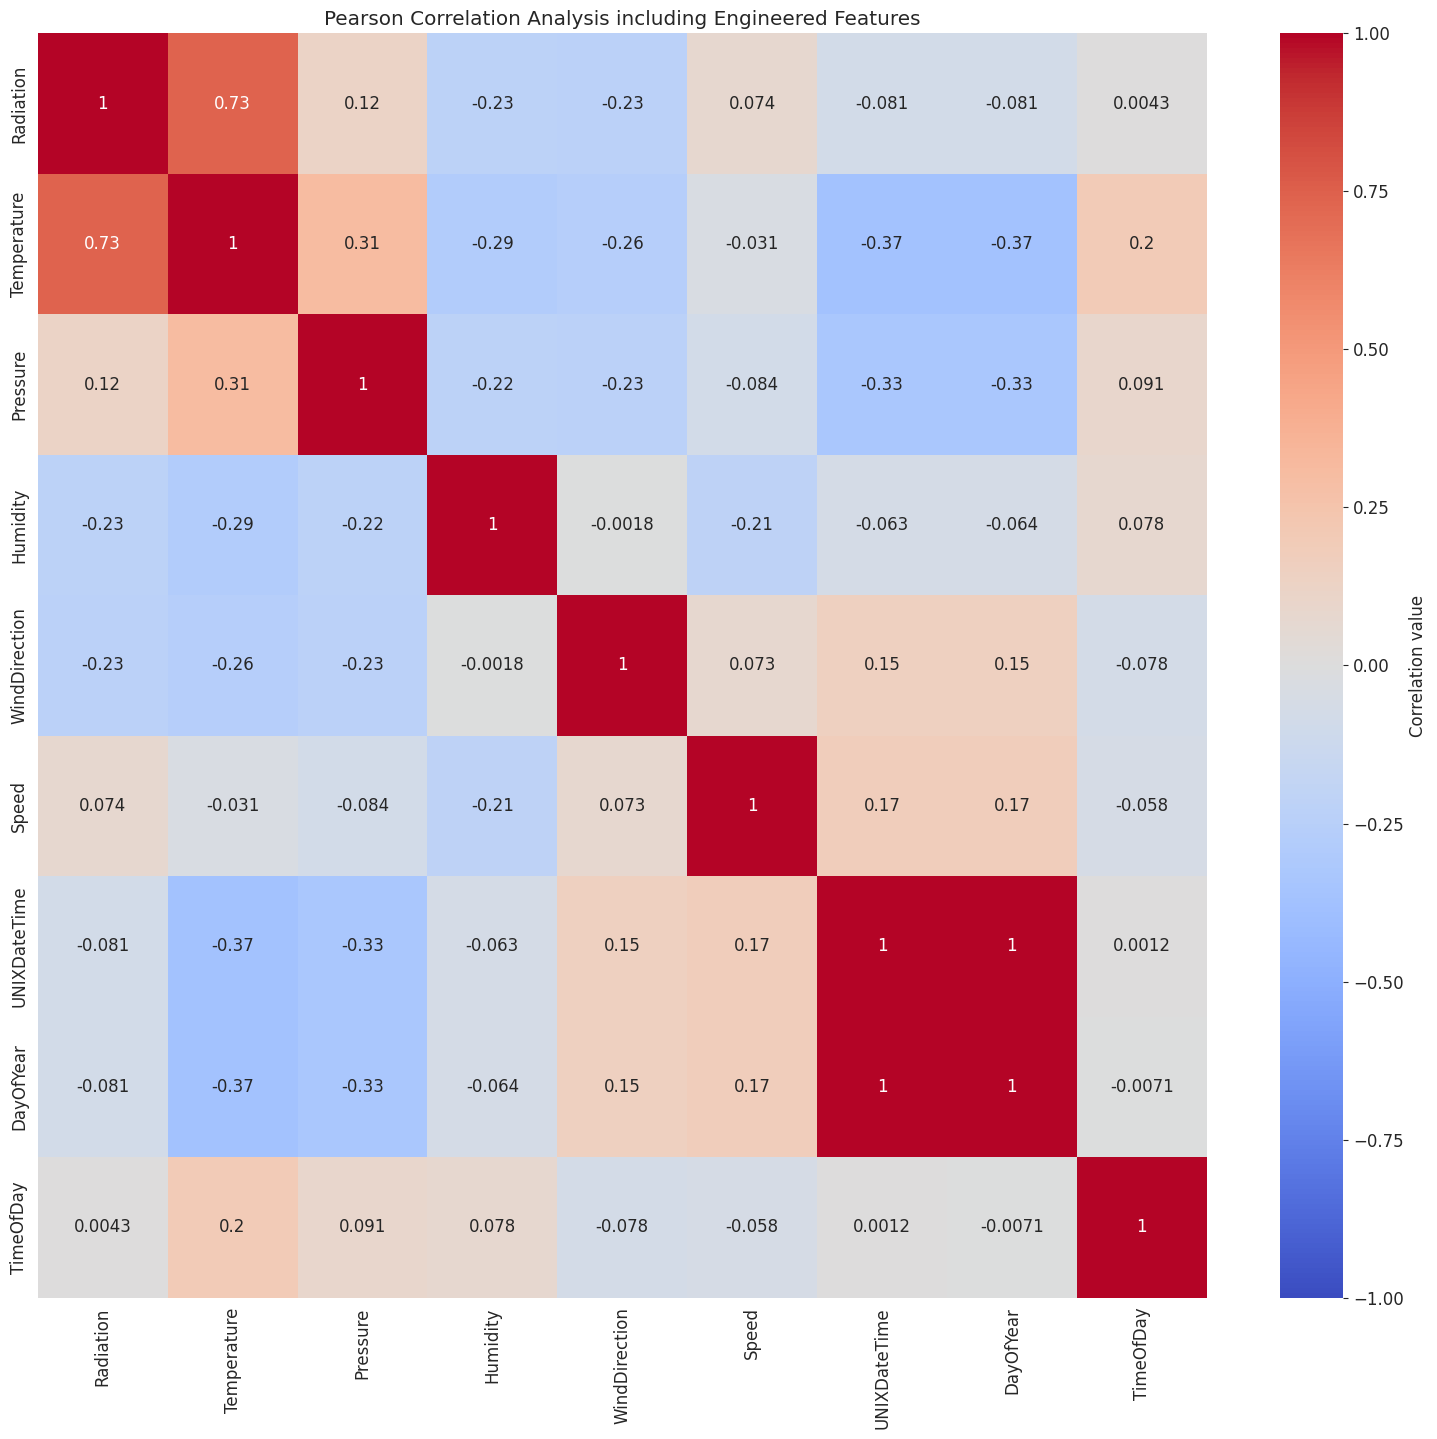

In [96]:
# Drop the Object columns
df_filtered = df.drop(columns=['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'])

fig, ax = plt.subplots(figsize=[15, 15], sharex=True)

# Calculate the correlation matrix, dropping all NaN rows and columns
correlation_matrix = df_filtered.corr(method='pearson').dropna(axis=0, how='all').dropna(axis=1, how='all')

# Plot the results of the correlation as a heatmap
sns.heatmap(correlation_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm', cbar_kws={'label': 'Correlation value'})
plt.title("Pearson Correlation Analysis including Engineered Features")
ax.set_position([0.55, 0.1, 0.35, 0.8])  # Adjust position manually

plt.tight_layout()
plt.show()

## Preprocessing

---


The radiation values can be used directly. Instead of needing to encode values, I focused on properly splitting and standardizing the data. Because the target variable radiation is so heavily skewed, it would impact correct predictions. I tried a variety of methods to transform the data including Logarithmic Transformation(both natual log and log base 10), Square Root Transformation, Cube Root Transformation and Reciprocal Transformation. However, none of these methods really seemed to work. I also tried to apply power tansformers including the Box-Cox Transformation
and Yeo-Johnson Transformation to help stabilize variance and make the target variable more normally distributed. These attempts also failed. Nonetheless, utilizing the Quantile Transformer from Sci-Kit Learn did help to normalize my target variable.

**However**, for the final submission, I found that **not transforming** my target data, but instead applying **feature engineering** actually gave me much better results. The addition of the time of day seemd to greatly increase scores.

I also used the quntiles to remove outliers, as those values seemed to greatly skew results for the models. This removed several thousand values but still left me with over 27,000 samples. However, removing the outliers seemed to make scores worse as well, so outlier removal was not performed.



In [17]:
# Rename the  column WindDirection
df = df.rename(columns={'WindDirection(Degrees)': 'WindDirection'})

columns = ['Temperature', 'Humidity', 'Speed', 'Pressure', 'WindDirection', 'Radiation', 'DayOfYear', 'TimeOfDay']
features = ['Temperature', 'Humidity', 'Pressure', 'WindDirection', 'DayOfYear', 'TimeOfDay']

# Pull out just the features I want to use
X_df =  df[columns]

In [18]:
# Set the Feature Vectors
X = X_df[features]
# Set the target variables
y = X_df['Radiation']

## Splitting the Data


---


Because of the time series feature in the data that can be see in the EDA above, I orignally performed a Time Series Split on the data. However, after looking at my results, I noticed that the Time Series split seemed to give me worse results than I would expect. Not sure if this is because the time period is very short (only 4 months) or if there was some other issue. However, because of this I switched back to just the random split on the data.

In [19]:
# No stratified split of train, test and validation sets becuase the target is continous
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Importance Analysis and Final Feature Selection


---

I used the Random Forest Regrssor algorithm to determine the feature importance for my data set. I used the regressor and a loop to remove the least important feature, fit the features to the Random Forest Regressor and then determine the R-squared score. The scores are collected for each iteration and then compaed at the end to determine the best R-squared score given the features. These scores are shown below, as well as a plot of the final selected features which give the highest R-Square scores. The plot makes sense as there is a high correlation between temperature and radiation in the Pearson Correlation Matrix.

In [20]:
regressor = RandomForestRegressor(n_estimators = 100)
regressor.fit(X_train, y_train)
feature_importances = regressor.feature_importances_

# Convert X_train to a pandas DataFrame
X_train_feature_options = pd.DataFrame(X_train, columns=features)

removed_columns = pd.DataFrame()
models = []
r2s_opt = []

for i in range(0,5):
    least_important = np.argmin(feature_importances)

    # Remove the least important feature
    removed_columns = pd.concat([removed_columns, X_train_feature_options.pop(X_train_feature_options.columns[least_important])], ignore_index=True)

    # Convert back to NumPy array for regressor
    X_train_opt_np = X_train_feature_options.to_numpy()

    regressor.fit(X_train_opt_np, y_train)

    feature_importances = regressor.feature_importances_
    accuracies = cross_val_score(estimator = regressor,
                                 X = X_train_opt_np,
                                 y = y_train, cv = 5,
                                 scoring = 'r2')
    r2s_opt = np.append(r2s_opt, accuracies.mean())
    models = np.append(models, ", ".join(list(X_train_feature_options)))

In [21]:
# Add the features in a Pandas Dataframe
pd.set_option('display.max_colwidth', None)
feature_selection = pd.DataFrame({'Features':models,'r2 Score':r2s_opt})
print(feature_selection.head())

                                                     Features  r2 Score
0  Temperature, Humidity, WindDirection, DayOfYear, TimeOfDay  0.930250
1                 Temperature, Humidity, DayOfYear, TimeOfDay  0.932575
2                           Temperature, DayOfYear, TimeOfDay  0.932326
3                                      Temperature, TimeOfDay  0.798843
4                                                 Temperature  0.603730


The Features were looped through and the highest R-squared score is the combo of Temperature, Humidity, DayOfYear, TimeOfDay. I will use these as the input features for all model types.

In [22]:
# Create a list for the best feature set
best_feature_set = feature_selection.loc[feature_selection['r2 Score'].idxmax()]['Features'].split(', ')

In [23]:
print(f"The feature set with the highest R-squared score included these features: {best_feature_set}")

The feature set with the highest R-squared score included these features: ['Temperature', 'Humidity', 'DayOfYear', 'TimeOfDay']


In [24]:
# Grab the features that give the best R-Squared scores
best_X_train = X_train[best_feature_set]
best_X_test = X_test[best_feature_set]
# Sanity check to make sure the features are correct
best_X_train.head()

,Temperature,Humidity,DayOfYear,TimeOfDay
UNIXDateTime,,,,
2016-09-18 08:55:02-10:00,62,72,262,32102
2016-10-20 21:20:17-10:00,46,99,294,76817
2016-10-01 00:35:22-10:00,48,88,275,2122
2016-09-26 18:50:19-10:00,50,68,270,67819
2016-12-19 13:30:34-10:00,56,89,354,48634


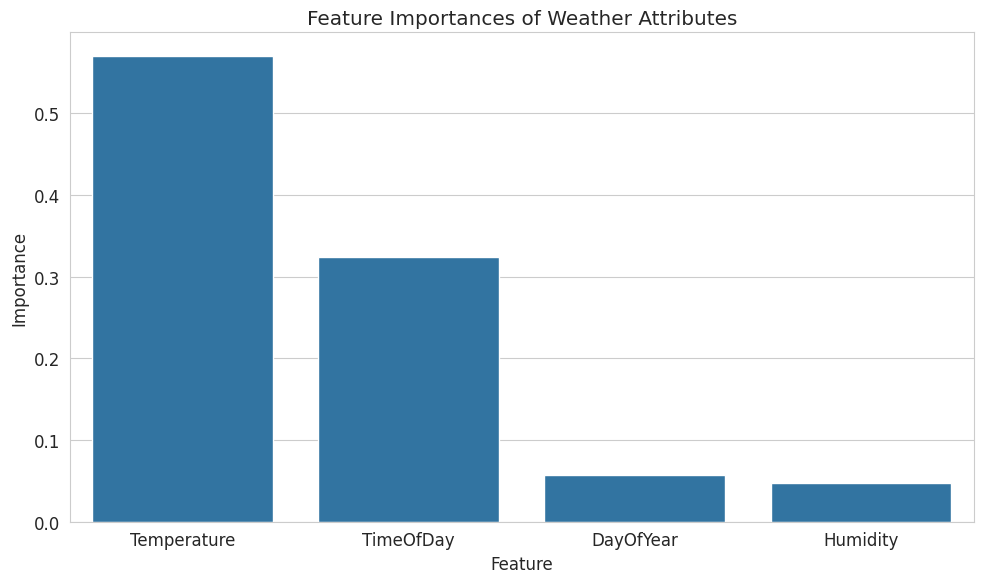

In [25]:
features = best_feature_set
# Create a Random Forest Classifier model
rf_model = RandomForestRegressor(random_state=42)

# Train the model
rf_model.fit(best_X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
# Use feature_importances DataFrame instead of df
ax = sns.barplot(x='Feature', y='Importance', data=feature_importances)
plt.title('Feature Importances of Weather Attributes')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

### <p style="text-align:center;"><i>Figure 7: Feature importance using a Random Forest Regressor. As shown in the Pearson Correlation matrix, there is a high correlation between temperature and radiation. This temperature is an important input feature.</i></p>

Based off the Random Forest Regressor the best features are include Temperature	Humidity, DayOfYear, TimeOfDay. As can be seen in the plot Temperature and TimeOfDay have the biggest influence on the model.

## Multi-Model Comparison Setup

---
As I wished to compare the results of the 3 algorithms below, plus various other regression algorithms/models, I will create a Dataframe to hold those results. These results will them be compared at the end of this notebook to show the models that performed the best. However, these results will not be completely accurate, as I only applied hyperparmeter tuning to the XGBoost Regressor.


In [26]:
df_models = pd.DataFrame(data=None, columns=['Algorithm', 'r2_train', 'r2_test', 'mse_train', 'mse_test', 'rmse_train', 'rmse_test', 'mae_train','mae_test'])

In [27]:
def make_model(X_tr, X_te, y_tr, y_te, model, model_name: str):
    model.fit(X_tr, y_tr)
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)
    r2_train = r2_score(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    df_models.loc[len(df_models.index)] = [model_name, r2_train, r2_test, mse_train, mse_test, rmse_train, rmse_test, mae_train, mae_test]

## XGBoost Regressor

---

For the XGBoost Regressor I ran hyperparameter tuning with the GridSearchCV algortihm. Because hyperparmeter tuning takes quite a long time to run, I copied the best parameters in the Markdown in below the cell. I originally used Mean Absolute Error as my evaluation metric, but decided to change to mean absoulte error, although I did get similar results with the different metrics.

In [28]:
#This takes a long time to run, so it has been commented out
"""regressor=XGBRegressor(eval_metric='rmse')

# set up our search grid
param_grid = {"max_depth":    [4, 5, 6, 7, 8],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.001, 0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(best_X_train, y_train)
print("The best hyperparameters are ",search.best_params_)"""

'regressor=XGBRegressor(eval_metric=\'rmse\')\n\n# set up our search grid\nparam_grid = {"max_depth":    [4, 5, 6, 7, 8],\n              "n_estimators": [500, 600, 700],\n              "learning_rate": [0.001, 0.01, 0.015]}\n\n# try out every combination of the above values\nsearch = GridSearchCV(regressor, param_grid, cv=5).fit(best_X_train, y_train)\nprint("The best hyperparameters are ",search.best_params_)'

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 8, 'n_estimators': 600}

In [29]:
regressor=XGBRegressor(learning_rate = 0.015,
                       n_estimators  = 600,
                       max_depth     = 8,
                       eval_metric='mae',
                       objective="reg:squarederror",
                        )

regressor.fit(best_X_train,
            y_train,
            verbose=0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [30]:
#Making predictions on the test set and train sets for comparison
y_pred_train = regressor.predict(best_X_train)
y_pred_test = regressor.predict(best_X_test)

In [31]:
# Calculate the mean squared error, R-squared score, root mean error and mean absolute error
make_model(best_X_train, best_X_test, y_train, y_test, regressor, 'XGBoost')

row = df_models[df_models['Algorithm'] == 'XGBoost']

# Print the selected row
print(f"R-squared Score: {row['r2_test'].iloc[0]}")
print(f"Mean Squared Error: {row['mse_test'].iloc[0]}")
print(f"Root Mean Squared Error: {row['rmse_test'].iloc[0]}")
print(f"Mean Absoulte Error: {row['mae_test'].iloc[0]}")


R-squared Score: 0.9407085088092474
Mean Squared Error: 5764.982703051457
Root Mean Squared Error: 75.92748318660021
Mean Absoulte Error: 30.184256831368845


I'm pretty happy with these scores compared to scores in my initial run. The R-square scores are extremely happy and the Mean Absoulte error is 30.18, which with radiation values that become quite large, could be somewhat acceptable. Although this model is not perfect and could still benefit from further refinement, possible the introduction of more engineered features, this iteration has improved on the previous version.

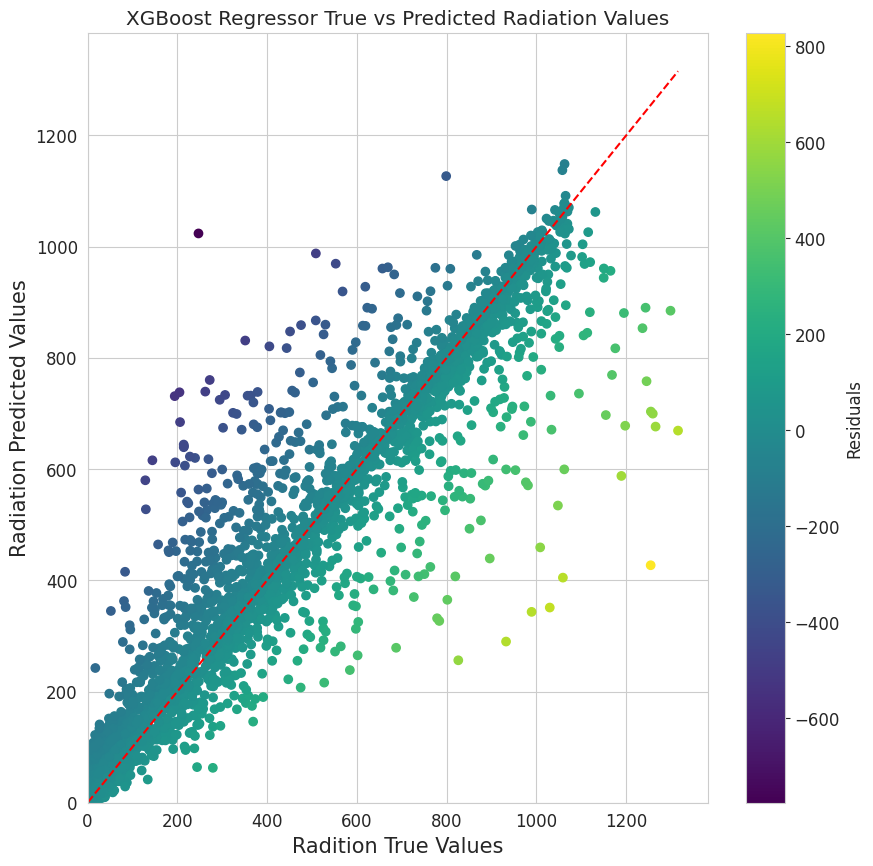

In [32]:
residuals = y_test - y_pred_test
# XGBoost Regression predicted values versus true values
plt.figure(figsize=(10, 10))
scatter = plt.scatter(y_test, y_pred_test, c=residuals, cmap='viridis')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
cbar = plt.colorbar(scatter)
cbar.set_label('Residuals')
plt.xlabel('Radition True Values', fontsize=15)
plt.ylabel('Radiation Predicted Values', fontsize=15)
plt.xlim(0)
plt.ylim(0)
plt.title("XGBoost Regressor True vs Predicted Radiation Values")

plt.show()

### <p style="text-align:center;"><i>Figure 8: True values vs predicted values with the residual using the XGBoost Regressor.</i></p>

I'm pretty happy with these results. The plot is much tighter than the previous version and a fair amount of the residuals are under 200. As discussed, I'm sure there could be additional feature engineering performed to improve these results, or possibly including additional data. Nonetheless, This model seems to do a pretty good job predicting the values given the R-squared and Mean absoulte error.

## Gradient Boosting Regression

---
In the first notebook I used Support Vector Regression, but that algorithm is computationally expensive and did not get good results with my new features (which can be seen in the final plots in the comparison section). Instead I decide the plot the results of the Gradient Boosting Regressor algotithm, as this algorithm got better results in my first submission.


In [85]:
# Train ElasticNet model
gbr_model =  GradientBoostingRegressor()
gbr_model.fit(best_X_train, y_train)

GradientBoostingRegressor()

In [86]:
# Evaluate the model
y_pred_train = gbr_model.predict(best_X_train)
y_pred_test = gbr_model.predict(best_X_test)

In [95]:
# Calculate the mean squared error, R-squared score, root mean error and mean absolute error
make_model(best_X_train, best_X_test, y_train, y_test, gbr_model, 'Gradient Boosting')

row = df_models[df_models['Algorithm'] == 'Gradient Boosting']

print(f"R-squared Score: {row['r2_test'].iloc[0]}")
print(f"Mean Squared Error: {row['mse_test'].iloc[0]}")
print(f"Root Mean Squared Error: {row['rmse_test'].iloc[0]}")
print(f"Mean Absoulte Error: {row['mae_test'].iloc[0]}")

R-squared Score: 0.8881468248368287
Mean Squared Error: 10875.618189843033
Root Mean Squared Error: 104.28623202438102
Mean Absoulte Error: 56.50645133572136


The R-squared and MAE are not as good for this model, but no tuning was applied to this model either. This algorithm might perform on par with the XGBoost Regressor if hyperparameter tuning was applied.

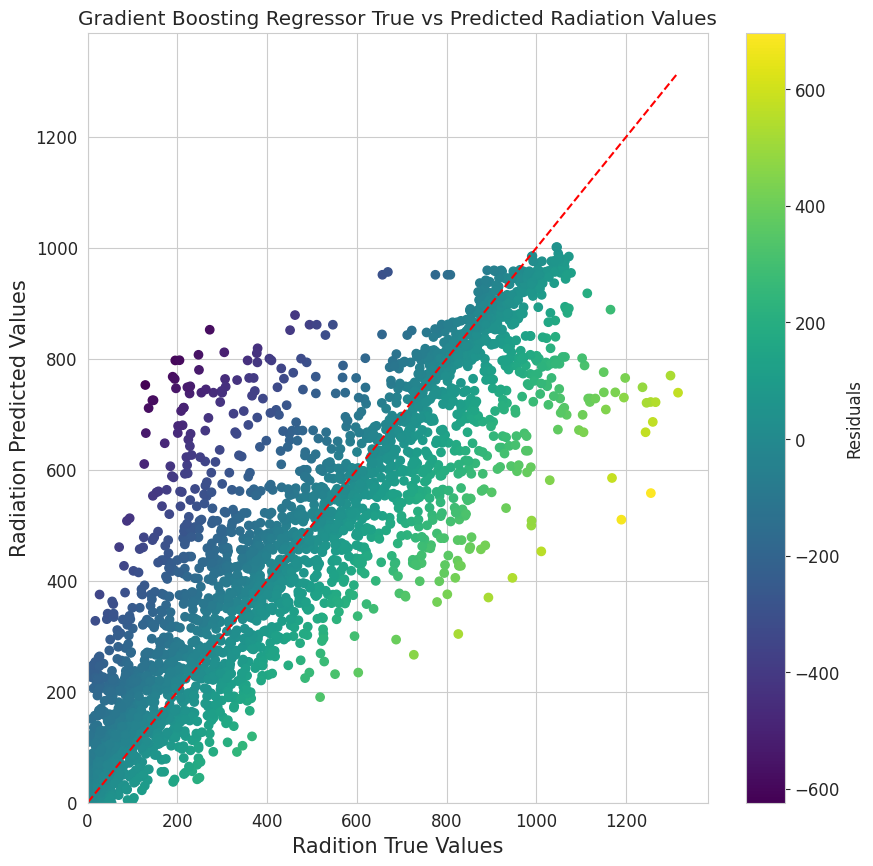

In [88]:
residuals = y_test - y_pred_test
# XGBoost Regression predicted values versus true values
plt.figure(figsize=(10, 10))
scatter = plt.scatter(y_test, y_pred_test, c=residuals, cmap='viridis')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
cbar = plt.colorbar(scatter)
cbar.set_label('Residuals')
plt.xlabel('Radition True Values', fontsize=15)
plt.ylabel('Radiation Predicted Values', fontsize=15)
plt.title("Gradient Boosting Regressor True vs Predicted Radiation Values")
plt.xlim(0)
plt.ylim(0)

plt.show()

### <p style="text-align:center;"><i>Figure 9: True values vs predicted values using the Gradient Boosting Regressor.</i></p>

## Linear Regression


---

I tried some different values for the Linear Regression model, but didn't apply hyperparmeter tuning. Despite the different values I tried, the model did not perform very well.

In [64]:
linear_model = LinearRegression(copy_X= True, fit_intercept=True, n_jobs=10, positive=False)

In [65]:
linear_model.fit(best_X_train, y_train)

LinearRegression(n_jobs=10)

In [66]:
# Evaluate the model
y_pred_train = linear_model.predict(best_X_train)
y_pred_test = linear_model.predict(best_X_test)

In [67]:
# Calculate the mean squared error, R-squared score, root mean error and mean absolute error
make_model(best_X_train, best_X_test, y_train, y_test, linear_model, 'Linear Regression')

row = df_models[df_models['Algorithm'] == 'Linear Regression']

# Print the selected row
print(f"R-squared Score: {row['r2_test'].iloc[0]}")
print(f"Mean Squared Error: {row['mse_test'].iloc[0]}")
print(f"Root Mean Squared Error: {row['rmse_test'].iloc[0]}")
print(f"Mean Absoulte Error: {row['mae_test'].iloc[0]}")

R-squared Score: 0.6119550416262225
Mean Squared Error: 37730.07607169195
Root Mean Squared Error: 194.2423127737413
Mean Absoulte Error: 148.36012325688262


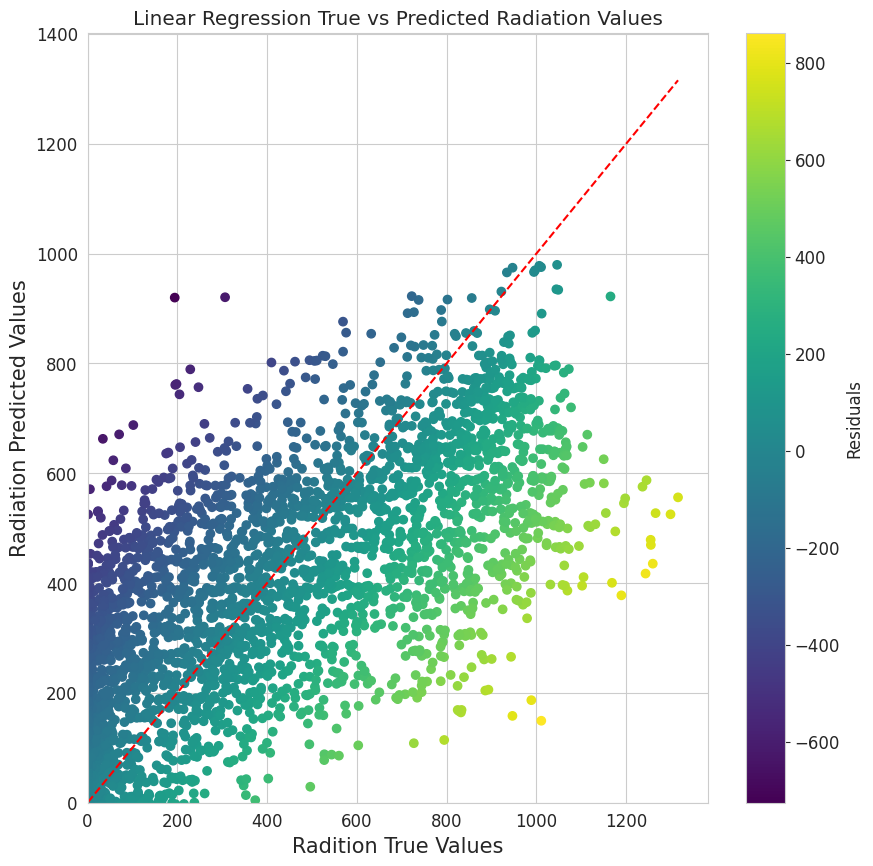

In [49]:
residuals = y_test - y_pred_test
# XGBoost Regression predicted values versus true values
plt.figure(figsize=(10, 10))
scatter = plt.scatter(y_test, y_pred_test, c=residuals, cmap='viridis')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
cbar = plt.colorbar(scatter)
cbar.set_label('Residuals')
plt.xlabel('Radition True Values', fontsize=15)
plt.ylabel('Radiation Predicted Values', fontsize=15)
plt.ylabel('Radiation Predicted Values', fontsize=15)
plt.title("Linear Regression True vs Predicted Radiation Values")
plt.xlim(0)
plt.ylim(0)

plt.show()

### <p style="text-align:center;"><i>Figure 10: True values vs predicted values using Linear Regression.</i></p>

The predicted values are pretty scattered for the Linear Regression model, and much more "loose" than the predictions made by the 2 different boosted algorithms. Based off the results and data, this model would probably not be a good one to use for prediction of radiation on this data set.

## Multiple Model Comparison and Results

---

I wanted to compare the R-Squared, MSE, RMSE and MAE scores for the 3 algorithms I looked at above to various other regression algorithms, to compare performance over a wide variety of different supervised regression techiques. I originally had the SVR algorithm included in my first analysis, but I did not get good scores from that model. Obviously my scores could improve slightly if I performed hyperparameter tuning for each algorithm, but my analysis of scores for multiple algorithms without much tuning shows which algorithms performed best on this data set and would show which models should be tuned to create a model for radiation prediction.

In [42]:
make_model(best_X_train, best_X_test, y_train, y_test, Ridge(), 'Ridge')
make_model(best_X_train, best_X_test, y_train, y_test, Lasso(), 'Lasso')
make_model(best_X_train, best_X_test, y_train, y_test, SVR(), 'SVR')
make_model(best_X_train, best_X_test, y_train, y_test, ElasticNet(), 'Elastic Net')
make_model(best_X_train, best_X_test, y_train, y_test, RandomForestRegressor(), 'RandomForest')

In [43]:
fig = go.Figure(data=[
    go.Bar(name='r2_train', x=df_models.Algorithm, y=df_models.r2_train),
    go.Bar(name='r2_test', x=df_models.Algorithm, y=df_models.r2_test)
])
fig.update_layout(template='plotly_dark', title='R2 for Train and Test Sets for Various Regression Algorithms', title_x=0.5)

### <p style="text-align:center;"><i>Figure 11: R-Square comparison of several different models for train and test predictions.</i></p>

As can be seen in Figure 11, the XGBoost Regressor, Gradient Boosting Regressor and Random Forest give the best R-squared scores with minimal or no hyperparmeter tuning. As tuning will only improve model performance slightly, the best choice for this problem would probably be one of these algorithms.

In [44]:
fig = go.Figure(data=[
    go.Bar(name='mse_train', x=df_models.Algorithm, y=df_models.mse_train),
    go.Bar(name='mse_test', x=df_models.Algorithm, y=df_models.mse_test)
])
fig.update_layout(template='plotly_dark', title='MSE for Train and Test Sets for Various Regression Algorithms', title_x=0.5)

### <p style="text-align:center;"><i>Figure 12: MSE comparison of several different models for train and test predictions.</i></p>

In [45]:
fig = go.Figure(data=[
    go.Bar(name='rmse_train', x=df_models.Algorithm, y=df_models.rmse_train),
    go.Bar(name='rmse_test', x=df_models.Algorithm, y=df_models.rmse_test)
])
fig.update_layout(template='plotly_dark', title='RMSE for Train and Test Sets for Various Regression Algorithms', title_x=0.5)

### <p style="text-align:center;"><i>Figure 13: RMSE comparison of several different models for train and test predictions.</i></p>

In [46]:
fig = go.Figure(data=[
    go.Bar(name='mae_train', x=df_models.Algorithm, y=df_models.mae_train),
    go.Bar(name='mae_test', x=df_models.Algorithm, y=df_models.mae_test)
])
fig.update_layout(template='plotly_dark', title='MAE for Train and Test Sets for Various Regression Algorithms', title_x=0.5)

### <p style="text-align:center;"><i>Figure 14: RMSE comparison of several different models for train and test predictions.</i></p>

## Conclusion

---

Looking at the 4 metrics above, the XGBoost Regressor seems to perform slightly better than others on the test data, although Random Forest performs just slightly better on the testing data. Feature engineering in this notebook creating a feature for time of daya and day of the year appears to improved results. I also found that scores improved when I removed my scaling, as I think that the Time Series Split that I was attempting to use might have imapcted my models dues to the small time period of only 4 months.

In the previous notebook I also applied a Quantile Scaler to my target variable. However, upon the incorporation of feature engineering, it appears that it was no longer necessary to utilize that scaling as it actually made the scoring worse.

This project definitely taught me a lot about experimentation, as well as the importance of the features and the usefulness of feature engineering. I had considered binning the target variable, removing outliers, and even completely removing some of the data that was skewing the results. Nonetheless, the use of the extra features greatly improved my results and will be something I will remeber to consider and incorporate in future work.

## Questions

---

1. **Which method did you like the most?**
The XGBooost Regression modle did quite well based of the R-Squared, MSE, RMSE and MAE scores. I did a small amount of hyperparmeter tuning for this algorithm, but my multiple model comparison plots show that the XGboost, along with the Gradient Boosted Regressor and Random Forest have the best performance on this data set.
1. **Which method did you like the least?**
In my last step I ran the data through several algorithms and SVR did the worst according to the 4 different scores scores, so this would be the method I liked the least based off performance with no hyperparameter tuning.
1. **How did you score these supervised models?**
I scored the models using R-squared, MSE, RMSE and MAE. I decided to add the RMSE and MAE in this final notebook to provide more ways of scoring the models.
1. **Did the output align with your geologic understanding?**
The target variable for this assignment was heavily right-skewed, which I believe majorly impacted the models. It fits with my geological understanding, because radiation levels on Earth, even where the data was collected, would remain relatively low due to the electromagnetic field that protects Earth, although solar flares and solar storms may cause sudden bursts of high radiation, which is shown in the data. The addition of time of day and day of the year via feature engineering reinforced by understanding a bit more. Temperature is correlated to radiation and the temperature would be highest midday. The temperatures will also be higher during summer months than winter months. Therefore, I believe the introduction of these features showed to increase performance as they better explain the samples from a meterological standpoint.
1. **What did you want to learn more about?**
I want to determine a better way to deal with the skewed target values, as I believe it was and still is majorly impacting performance. I attempted a variety of different transformations to fix the issue, but the Quantile Transform somewhat fixed the issue. I tried applying both the normal and uniform output distribution parameter for that transform and seemed to get better performance with the uniform output distribution. However, it seems that feature engineering seemed to increase performance and gave better results. I was glad that I looked into that as part of my solution, as I believe the additional features helped give a better representation of the data.
1. **Did you pre-process your data?**
Yes, as described in the previous question, I applied a transformation to radiation, which was my target variable. I sorted the data by time, then dropped the time and date columns as they were not needed. I originally applied a Standard Scaler to all of my feature vectors, but ut didn't seem to improve results much. I also used the TimeSeriesSplit object to split my data after I sorted it, because I was concerned that there might be some autocorrelation due to the fact that the data was collected over 4 months. This actually made the models perform worse, as I think 4 months was to short of a time period. I used feature engineering and feature selection in this final submission, which resulted in great improvement to the model scores.
1. **Do all models require pre-processing?**
Yes, all the models require pre-processing due to addition of new features and feature selection. If preprocessing was not performed, it would greatly impact model performance.
